# Titanic - Machine Learning from Disaster - Kaggle Competition

## Reading in the data

I will be making use of the data found in the following Kaggle dataset: https://www.kaggle.com/c/titanic/overview

Importing the libraries that I will be making use of:

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Since I am using Jupyter Notebook and I would like to see plots displayed directly below the code cells that produce them, I must use the following:

In [159]:
%matplotlib inline

The data is split into training data and test data. For this project,I will be training our model on a split of the training data, with the remaining training data being used as test data. Read in the training data CSV as a Pandas dataframe:

In [160]:
titanic_train = pd.read_csv('train.csv')

In [161]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [162]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The training data above has a column named "Survived". I will be using Logistic Regression to predict whether passengers in the test data survived or perished. Logistic regression is a technique that can be used for binary classification (in this case predicting whether or not the passenger survived).

## Data visualisation

### This section is just to explore the data and gain some preliminary insight. You can skip to the feature engineering section if you don't want to view this.

Let's look at the correlation between the 'Survived' column and other numeric columns.

In [163]:
titanic_train.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

<br>

<AxesSubplot:xlabel='Survived', ylabel='count'>

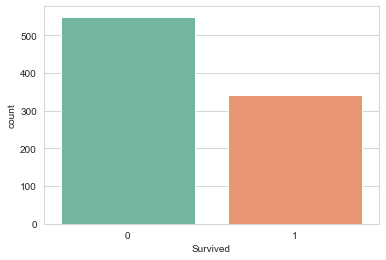

In [164]:
sns.countplot(x='Survived',data=titanic_train,palette='Set2')

How many people survived and how many perished?

<br>

More people perished than survived.

<br>

How did this differ between males and females?

<AxesSubplot:xlabel='Survived', ylabel='count'>

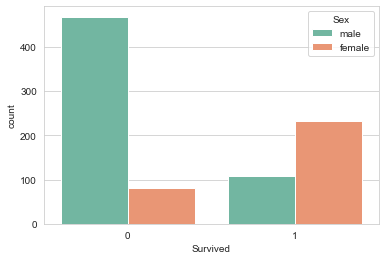

In [165]:
sns.countplot(x='Survived',data=titanic_train,hue='Sex',palette='Set2')

Passengers that perished were much more likely to be male.

<br>

Let's take a look at passenger class:

<AxesSubplot:xlabel='Survived', ylabel='count'>

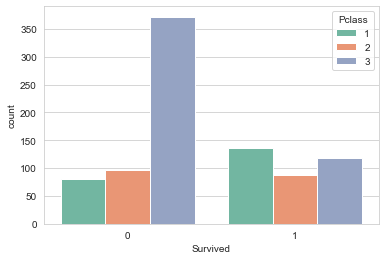

In [166]:
sns.countplot(x='Survived',data=titanic_train,hue='Pclass',palette='Set2')

The largest number of people who perished had 3rd Class tickets. However, this data is not very useful as we need to look at how many tickets of each class were sold overall.

<br>

Let's take a look at the distribution of the cost of tickets.

<AxesSubplot:>

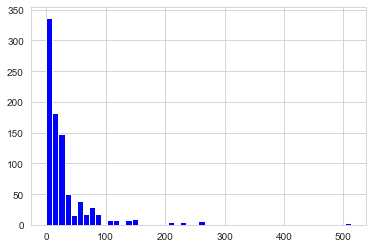

In [167]:
titanic_train['Fare'].hist(color='blue',bins=50)

Let's see if there is a link between cost of ticket and whether or not the passenger survived as we saw some correlation earlier.

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

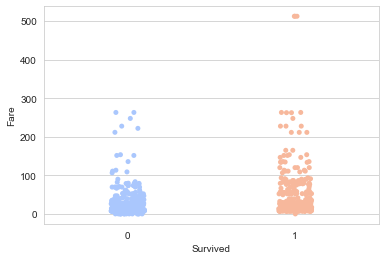

In [168]:
sns.stripplot(x="Survived", y="Fare", data=titanic_train,palette='coolwarm')

The plot above doesn't show a clear visual link.

What if we make the hue 'Sex'?

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

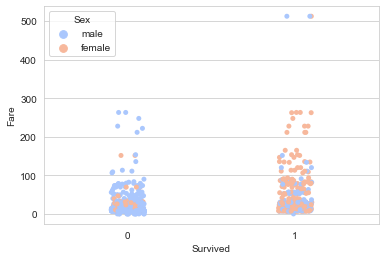

In [169]:
sns.stripplot(x="Survived", y="Fare", data=titanic_train,palette='coolwarm',hue='Sex')

<br>

## Feature engineering

Use Seaborn to quickly see if we have any missing data in the dataset.

<AxesSubplot:>

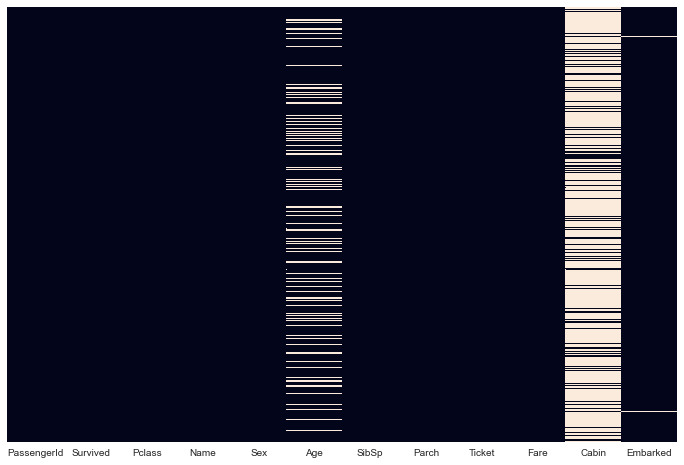

In [170]:
plt.figure(figsize=(12,8))
sns.heatmap(titanic_train.isnull(),yticklabels=False,cbar=False,cmap='rocket')

It looks like there is missing data in the 'Age' column ,the 'Cabin' column and the 'Embarked' column.

In [171]:
titanic_train['Age'].isnull().sum()/891

0.19865319865319866

The calculation above shows that approximately 20% of the age data is missing for the passengers. I can use imputation to replace these null values. The "Cabin" column appears to have too much missing data to do something useful with it at a basic level so this column will be dropped as I am only doing basic analysis. I can drop the two rows that appear to have 'Embarked' data missing.

I could use the average age of the passengers to fill in this missing data. However, there is a smarter way to do this. Let's look at the correlation between 'Age' and other columns.

In [172]:
titanic_train.corr()['Age']

PassengerId    0.036847
Survived      -0.077221
Pclass        -0.369226
Age            1.000000
SibSp         -0.308247
Parch         -0.189119
Fare           0.096067
Name: Age, dtype: float64

There appears to be slight negative correlation between the passenger's Class and their age. Taking a closer look shows:

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

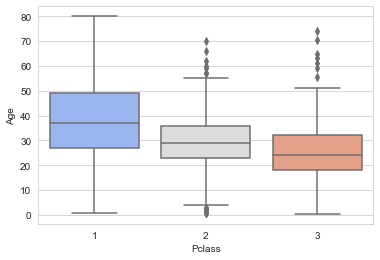

In [173]:
sns.boxplot(x='Pclass',y='Age',data=titanic_train,palette='coolwarm')

I can see that passengers who were in first class tend to be older than those in second and third class. I can use these average age values to impute based on 'Pclass' for 'Age'.

Working out the average age per class:

In [174]:
titanic_train.groupby(['Pclass'])['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [175]:
def new_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 38.233441

        elif Pclass == 2:
            return 29.877630

        else:
            return 25.140620

    else:
        return Age

In [176]:
titanic_train['Age'] = titanic_train[['Age','Pclass']].apply(new_age,axis=1)

Checking the heatmap again:

<AxesSubplot:>

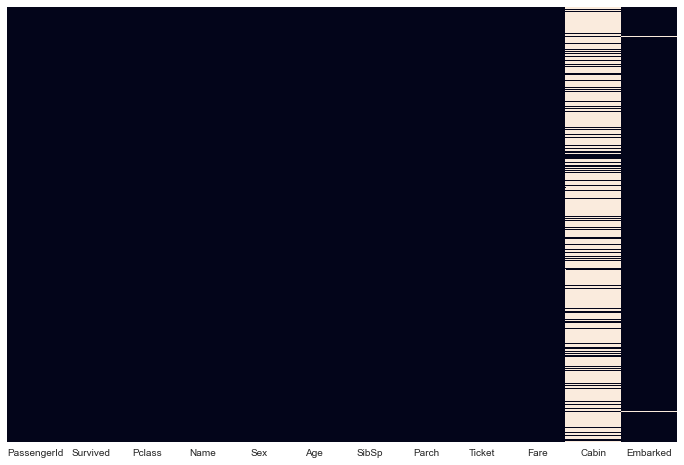

In [177]:
plt.figure(figsize=(12,8))
sns.heatmap(titanic_train.isnull(),yticklabels=False,cbar=False,cmap='rocket')

Now I can drop the 'Cabin' column and the two rows in 'Embarked' that are NaN.

In [178]:
titanic_train.drop('Cabin',axis=1,inplace=True)

In [179]:
titanic_train.dropna(inplace=True)

In [180]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


We have now filled in/dropped all missing data.

Next, I will drop the 'Name' and 'Ticket' columns as these are text heavy fields and will be difficult to code into a machine learning algorithm.

In [181]:
titanic_train.drop(['Name','Ticket'],axis=1,inplace=True)

<AxesSubplot:>

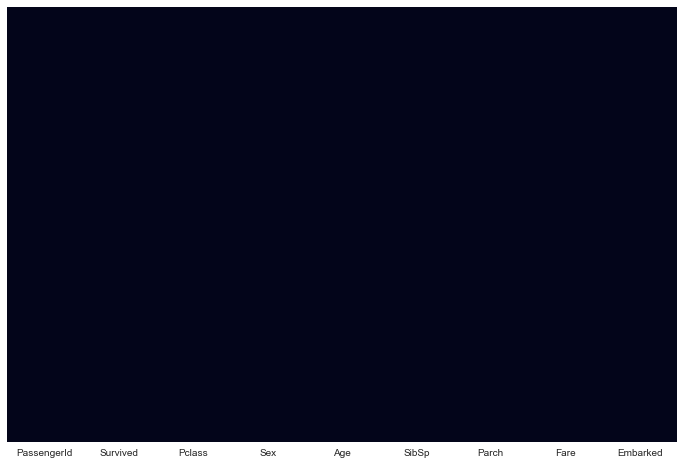

In [182]:
plt.figure(figsize=(12,8))
sns.heatmap(titanic_train.isnull(),yticklabels=False,cbar=False,cmap='rocket')

The heatmap above shows that there is no missing data.

## Converting categorical features

### Categorical features will need to be converted to dummy variables so that the algorithm can take in these features as inputs

In [183]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 69.5+ KB


The 'Sex'and 'Embarked' columns need to be converted into dummy variables. We can use the Pandas get_dummies method to do this.

In [185]:
sex = pd.get_dummies(titanic_train['Sex'],drop_first=True)
embark = pd.get_dummies(titanic_train['Embarked'],drop_first=True)

In [187]:
titanic_train.drop(['Sex','Embarked'],axis=1,inplace=True)

In [188]:
titanic_train = pd.concat([titanic_train,sex,embark],axis=1)

In [189]:
titanic_train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


The data is now ready to be put into the model.

# Building a Logistic Regression Model

## Train Test Split

Since I am only using the training data, I will split the data into a training set and a test set. I will use 70% of the data for training and the remaining 30% to test.

In [203]:
from sklearn.model_selection import train_test_split

In [204]:
X_train, X_test, y_train, y_test = train_test_split(titanic_train.drop('Survived',axis=1), 
                                                    titanic_train['Survived'], 
                                                    test_size=0.3)

## Training and Predicting

In [205]:
from sklearn.linear_model import LogisticRegression

In [220]:
logmodel = LogisticRegression(max_iter=450)
logmodel.fit(X_train,y_train)

LogisticRegression(max_iter=450)

In [221]:
predictions = logmodel.predict(X_test)

Now that the model has been trained and predictions have been made, I can evaluate the predictions.

# Evaluating performance of model

In [227]:
from sklearn.metrics import classification_report, confusion_matrix

In [228]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       161
           1       0.81      0.74      0.77       106

    accuracy                           0.83       267
   macro avg       0.82      0.81      0.82       267
weighted avg       0.83      0.83      0.83       267



My model appears to have done well with an average accuracy of 0.82.

I will check the confusion matrix too:

In [229]:
confusion_matrix(y_test,predictions)

array([[143,  18],
       [ 28,  78]], dtype=int64)

There were 18 False Positives and 28 False Negatives

Thank you for viewing.

<br>